In [307]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [308]:
data = pd.read_excel('data/Education.xls', skiprows=range(4), usecols=['FIPS Code',
                                                'State', 'Area name',
                                                'Percent of adults with less than a high school diploma, 2012-2016',
                                                'Percent of adults with a bachelor\'s degree or higher, 2012-2016'],
                        converters={'FIPS Code': str})

In [309]:
data.columns=['FIPS', 'state', 'name', '< diploma', 'degree+']

Percentages of people who did not get a high school diploma and who got a bachelor's degree or higher.

In [310]:
data.head()

,FIPS,state,name,< diploma,degree+
0,00000,US,United States,13.021,30.315
1,01000,AL,Alabama,15.209,24.010
2,01001,AL,Autauga County,12.417,24.593
3,01003,AL,Baldwin County,9.972,29.547
4,01005,AL,Barbour County,26.236,12.868


In [311]:
data['FIPS'] = data['FIPS'].apply(lambda x: x if x[2:5] != '000' else 'not county') # mark rows for US and states

In [312]:
data = data[data['FIPS'] != 'not county']

In [313]:
data = data[data['FIPS'] < '57000'] # remove Puerto Rico counties, which would be outliers for several features

In [314]:
data.head()

,FIPS,state,name,< diploma,degree+
2,01001,AL,Autauga County,12.417,24.593
3,01003,AL,Baldwin County,9.972,29.547
4,01005,AL,Barbour County,26.236,12.868
5,01007,AL,Bibb County,19.302,12.000
6,01009,AL,Blount County,19.969,13.050


In [315]:
data.tail()

,FIPS,state,name,< diploma,degree+
3199,56037,WY,Sweetwater County,9.315,21.371
3200,56039,WY,Teton County,4.634,53.788
3201,56041,WY,Uinta County,10.361,18.207
3202,56043,WY,Washakie County,12.577,21.076
3203,56045,WY,Weston County,8.592,18.807


In [316]:
population = pd.read_excel('data/Population.xls', skiprows=range(2), usecols=['FIPS','Urban_Influence_Code_2013',
                                                                              'CENSUS_2010_POP','POP_ESTIMATE_2014',
                                                                              'INTERNATIONALMIG_2010',
                                                                              'INTERNATIONALMIG-2011',
                                                                              'INTERNATIONAL_MIG_2012',
                                                                              'INTERNATIONAL_MIG_2013'],
                           converters={'FIPS': str, 'Urban_Influence_Code_2013': str})

*Note: The urban influence code is not a smooth scale from 1 = most urban to 12 = least urban. It includes several categories of county — metropolitan, suburban, rural — and then ranks within each category. So it must be treted as categorical.*

In [317]:
population.columns = ['FIPS', 'urban_inf', 'pop_2010', 'pop_2014', 'im1', 'im2', 'im3', 'im4']

The urban influence code "distinguishes metropolitan counties by population size of their metro area, and nonmetropolitan counties by size of the largest city or town and proximity to metro and micropolitan areas." Lower numbers are more urban. The other features being consteucted here are the change in poulation between 2010 and 2014, and the change in the international migrant population relative to the overall change. 

In [318]:
population['pop_inc'] = (population['pop_2014'] - population['pop_2010']) / population['pop_2010']

In [319]:
population['foreign_inc'] = (population['im1'] + population['im2'] + population['im3'] + population['im4']
                            ) / (population['pop_2014'] - population['pop_2010'])
# increase in foreign population divided by the total population increase 

In [320]:
add_pop = population.drop(['pop_2010', 'im1', 'im2', 'im3', 'im4'], axis=1)

In [321]:
add_pop.head(6)

,FIPS,urban_inf,pop_2014,pop_inc,foreign_inc
0,00000,NaN,318622525,0.031991,0.289381
1,01000,NaN,4840037,0.012616,0.232285
2,01001,2,54864,0.005369,0.040956
3,01003,2,199064,0.092168,0.030359
4,01005,6,26749,-0.025786,0.033898
5,01007,1,22533,-0.016670,-0.102094


Where the population increase is negative, the foreign increase must be multiplied by -1 so that the division in the calculation does not turn a positive foreign increase negative and vice-versa.

In [322]:
add_pop['foreign_inc'] = add_pop['foreign_inc'] * (add_pop['pop_inc'] / abs(add_pop['pop_inc']))

In [323]:
add_pop.head(6)

,FIPS,urban_inf,pop_2014,pop_inc,foreign_inc
0,00000,NaN,318622525,0.031991,0.289381
1,01000,NaN,4840037,0.012616,0.232285
2,01001,2,54864,0.005369,0.040956
3,01003,2,199064,0.092168,0.030359
4,01005,6,26749,-0.025786,-0.033898
5,01007,1,22533,-0.016670,0.102094


In [324]:
data = data.set_index('FIPS').join(add_pop.set_index('FIPS'))

In [325]:
unemployment = pd.read_excel('data/Unemployment.xls', skiprows=range(7), usecols=['FIPStxt', 'Unemployment_rate_2014'],
                            converters={'FIPStxt': str})
unemployment.columns = ['FIPS', 'unemployment']
unemployment = unemployment.set_index('FIPS')
unemployment2 = pd.read_excel('data/CLF01.xls', sheetname='Sheet9', usecols=['STCOU', 'CLF040210D'], converters={'STCOU': str})
unemployment2.columns = ['FIPS', 'unemployment_2009']
unemployment = unemployment.join(unemployment2.set_index('FIPS'))
unemployment['unemp_change'] = unemployment['unemployment'] - unemployment['unemployment_2009']
data = data.join(unemployment.drop('unemployment_2009', axis=1))

The features are the unemployment rate in 2014 and the change in that rate from 2009.

In [326]:
poverty = pd.read_excel('data/Poverty.xls', skiprows=range(2), usecols = ['FIPStxt',
                                                                         'PCTPOVALL_2014','MEDHHINC_2014'],
                       converters={'FIPStxt': str})
poverty.columns = ['FIPS', 'poverty', 'median_hh_inc'] # poverty rate and median household income
poverty = poverty.set_index('FIPS')
poverty2 = pd.read_excel('data/IPE01.xls', sheetname='Sheet5', usecols=['STCOU', 'IPE120209D'], converters={'STCOU': str})
poverty2.columns = ['FIPS', 'poverty_2009']
poverty = poverty.join(poverty2.set_index('FIPS'))
poverty['pov_change'] = poverty['poverty'] - poverty['poverty_2009']
data = data.join(poverty.drop('poverty_2009', axis=1))

Similarly, the poverty rate in 2014 and the change from 2009.

In [327]:
age = pd.read_excel('data/AGE01.xls', sheetname='Sheet2', usecols=['STCOU', 'AGE050210D'], converters={'STCOU': str})
age.columns = ['FIPS', 'median_age']
data = data.join(age.set_index('FIPS'))

In [328]:
households1 = pd.read_excel('data/HSG02.xls', sheetname='HSG02D', usecols=['HSG200210D'])
households2 = pd.read_excel('data/HSG02.xls', sheetname='HSG02E', usecols=['STCOU', 'HSG215210D', 'HSG220210D'],
                          converters={'STCOU': str})
households2.columns = ['FIPS', 'hh_afr_am', 'hh_hisp']

Divide the numbers of households headed by African-Americans and Hispanics by the total number of households to get percentages.

In [329]:
households2.loc[:, ['hh_afr_am', 'hh_hisp']] = households2[['hh_afr_am', 'hh_hisp']].div(households1['HSG200210D'], axis=0)
data = data.join(households2.set_index('FIPS'))

In [330]:
hh_07 = pd.read_excel('data/HSD01.xls', sheetname='HSD01I', usecols=['HSD410209D'])

In [331]:
hh_female = pd.read_excel('data/HSD02.xls', sheetname='HSD02B', usecols=['STCOU', 'HSD570209D'],
                          converters={'STCOU': str})

In [332]:
hh_female.columns = ['FIPS', 'hh_female']
hh_female.loc[:, 'hh_female'] = hh_female['hh_female'] / hh_07['HSD410209D']

In [333]:
hh_food_st = pd.read_excel('data/INC01.xls', sheetname='INC01J', usecols=['STCOU', 'INC454209D'],
                          converters={'STCOU': str})

In [334]:
hh_food_st.columns = ['FIPS', 'hh_food_st']
hh_food_st.loc[:, 'hh_food_st'] = hh_food_st['hh_food_st'] / hh_07['HSD410209D']

In [335]:
data = data.join([hh_female.set_index('FIPS'), hh_food_st.set_index('FIPS')])

In [336]:
foreign_born = pd.read_excel('data/POP02.xls', sheetname='POP02J', usecols=['STCOU', 'POP645209D'],
                            converters={'STCOU': str})
foreign_born.columns = ['FIPS', 'foreign_07']

In [337]:
pop_07 = pd.read_excel('data/PST01.xls', sheetname='Sheet4', usecols=['PST045207D'])

In [338]:
vets = pd.read_excel('data/VET01.xls', sheetname='VET01C', usecols=['STCOU', 'VET605209D', 'VET610209D'],
                    converters={'STCOU': str})
vets.columns = ['FIPS', 'vets', 'vets_male']

In [339]:
vets.loc[:, 'vets'] = vets['vets'] / pop_07['PST045207D']

In [340]:
data = data.join([foreign_born.set_index('FIPS'), vets.set_index('FIPS')])

In [341]:
crimes = pd.read_csv('data/Crime.tsv', sep='\t', usecols=['FIPS_ST', 'FIPS_CTY', 'VIOL', 'PROPERTY'],
                    converters={'FIPS_ST': str, 'FIPS_CTY': str, 'VIOL': float, 'PROPERTY': float}, engine='python')

In [342]:
crimes.columns = ['FIPS_ST', 'FIPS_CTY', 'viol_crime', 'prop_crime']
crimes.head()

,FIPS_ST,FIPS_CTY,viol_crime,prop_crime
0,1,1,144.0,1625.0
1,1,3,373.0,4060.0
2,1,5,97.0,660.0
3,1,7,23.0,227.0
4,1,9,125.0,1270.0


In [343]:
crimes['FIPS_ST'] = crimes['FIPS_ST'].apply(lambda x: '0' * (2 - len(x)) + x)

In [344]:
crimes['FIPS_CTY'] = crimes['FIPS_CTY'].apply(lambda x: '0' * (3 - len(x)) + x)

In [345]:
crimes['FIPS'] = crimes['FIPS_ST'] + crimes['FIPS_CTY']

In [346]:
data = data.join(crimes.drop(['FIPS_ST', 'FIPS_CTY'], axis=1).set_index('FIPS'))

In [347]:
data.loc[:, ['viol_crime', 'prop_crime']] = data[['viol_crime', 'prop_crime']].div(data['pop_2014'], axis=0)

In [348]:
data.isnull().sum()

state             0
name              0
< diploma        10
degree+          10
urban_inf        10
pop_2014         10
pop_inc          10
foreign_inc      13
unemployment     11
unemp_change     13
poverty          13
median_hh_inc    13
pov_change       13
median_age        9
hh_afr_am        11
hh_hisp          11
hh_female        11
hh_food_st       11
foreign_07        9
vets             11
vets_male         9
viol_crime       18
prop_crime       18
dtype: int64

In [349]:
len(data.dropna())

3130

In [350]:
len(data)

3152

Many of the missing values occur in records missing multiple values, and dropping all of them would only reduce the number of records from 3,152 to 3,130, so drop them.

In [351]:
data = data.dropna()

In [352]:
(data == 0).sum()

state              0
name               0
< diploma          0
degree+            0
urban_inf          0
pop_2014           0
pop_inc            0
foreign_inc      156
unemployment       0
unemp_change      11
poverty            0
median_hh_inc      0
pov_change        61
median_age         0
hh_afr_am         85
hh_hisp            4
hh_female          2
hh_food_st         3
foreign_07        33
vets               0
vets_male          0
viol_crime       163
prop_crime       100
dtype: int64

It is reasonable that these values could be zero, so proceed.

In [353]:
data.describe()

,< diploma,degree+,pop_2014,pop_inc,foreign_inc,unemployment,unemp_change,poverty,median_hh_inc,pov_change,median_age,hh_afr_am,hh_hisp,hh_female,hh_food_st,foreign_07,vets,vets_male,viol_crime,prop_crime
count,3130.000000,3130.000000,3.130000e+03,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000
mean,14.203396,20.789275,1.017577e+05,0.002831,0.395946,6.235559,-2.946709,16.837380,47121.392971,0.539904,40.336102,0.081055,0.060388,0.110043,0.104072,4.242971,0.088570,94.202109,0.002291,0.018038
std,6.539295,9.143450,3.263767e+05,0.041968,3.043823,2.256287,1.807379,6.422444,12099.573945,2.161624,5.033958,0.138236,0.114099,0.043623,0.058290,5.475315,0.022732,3.143674,0.001968,0.011847
min,1.279000,2.985000,8.900000e+01,-0.177510,-6.333333,1.200000,-13.600000,3.200000,21658.000000,-17.400000,22.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019065,65.000000,0.000000,0.000000
25%,9.282750,14.427500,1.102950e+04,-0.021689,0.007641,4.600000,-4.000000,12.100000,38889.000000,-0.700000,37.400000,0.002661,0.009502,0.082411,0.062540,1.100000,0.074039,92.900000,0.000981,0.009866
50%,12.765500,18.528000,2.574250e+04,-0.004227,0.057769,6.000000,-2.800000,15.800000,45227.500000,0.500000,40.300000,0.013111,0.019849,0.103899,0.093112,2.300000,0.087159,94.600000,0.001823,0.016319
75%,18.292750,24.703750,6.785250e+04,0.020261,0.200482,7.500000,-1.700000,20.400000,52529.750000,1.700000,43.300000,0.093166,0.053750,0.128855,0.134389,5.100000,0.100460,96.100000,0.003095,0.024298
max,51.479000,80.210000,1.007270e+07,0.727044,119.000000,24.000000,8.200000,47.400000,125635.000000,15.900000,62.700000,0.832707,0.955767,0.450570,0.400252,63.100000,0.297533,100.000000,0.025476,0.138286


From the stats, the dataset certainly contains strong outliers that will need to be dealt with.

In [354]:
deaths = pd.read_csv('data/Drug_deaths.csv', usecols=['FIPS', 'Year', 'Estimated Age-adjusted Death Rate, 16 Categories (in ranges)'],
                    converters={'FIPS': str})

In [355]:
deaths.isnull().sum()

FIPS                                                            0
Year                                                            0
Estimated Age-adjusted Death Rate, 16 Categories (in ranges)    0
dtype: int64

In [356]:
targets = deaths[deaths['Year'] == 2014]
targets = targets.drop('Year', axis=1)
targets.columns = ['FIPS', 'death_rate']
targets.loc[:, 'FIPS'] = targets['FIPS'].apply(lambda x: '0' + x if len(x) == 4 else x)

In [357]:
targets.isnull().sum()

FIPS          0
death_rate    0
dtype: int64

In [358]:
import re
def get_num(string):
    match = re.search('\d+', string)
    return int(match.group()) + 1

In [359]:
targets['numeric'] = targets['death_rate'].apply(lambda x: get_num(x) if x != '<2' else 1)

In [360]:
data = data.join(targets.set_index('FIPS')) # drop na

In [361]:
data.isnull().sum()

state            0
name             0
< diploma        0
degree+          0
urban_inf        0
pop_2014         0
pop_inc          0
foreign_inc      0
unemployment     0
unemp_change     0
poverty          0
median_hh_inc    0
pov_change       0
median_age       0
hh_afr_am        0
hh_hisp          0
hh_female        0
hh_food_st       0
foreign_07       0
vets             0
vets_male        0
viol_crime       0
prop_crime       0
death_rate       4
numeric          4
dtype: int64

In [362]:
data[data['death_rate'].isnull()]

,state,name,< diploma,degree+,urban_inf,pop_2014,pop_inc,foreign_inc,unemployment,unemp_change,...,hh_hisp,hh_female,hh_food_st,foreign_07,vets,vets_male,viol_crime,prop_crime,death_rate,numeric
FIPS,,,,,,,,,,,,,,,,,,,,,
08001,CO,Adams County,17.839,22.368,1,479488.0,0.085790,0.054824,5.7,-4.5,...,0.289450,0.114910,0.055541,15.3,0.071674,92.5,0.003418,0.028810,NaN,NaN
08014,CO,Broomfield County,3.948,52.457,1,61706.0,0.104081,0.045556,4.2,-3.7,...,0.080415,0.089699,0.027461,7.5,0.077482,93.9,0.000502,0.016854,NaN,NaN
08059,CO,Jefferson County,5.848,42.220,1,558519.0,0.044853,0.059893,4.6,-4.0,...,0.105262,0.096715,0.033976,6.4,0.088829,93.4,0.002333,0.027371,NaN,NaN
08123,CO,Weld County,12.995,26.762,2,275584.0,0.090019,0.018015,4.5,-5.7,...,0.212258,0.092415,0.048219,9.3,0.067942,94.2,0.002885,0.020204,NaN,NaN


These four counties had boundaries redrawn after 2000, and do not appear in the opioid deaths dataset, so they will be removed.

In [363]:
data = data.drop(['08001', '08014', '08059', '08123'])

In [364]:
targets['numeric'].describe()

count    3136.000000
mean       14.180485
std         6.583190
min         1.000000
25%         9.000000
50%        13.000000
75%        17.000000
max        31.000000
Name: numeric, dtype: float64

The maximum value of 31 fits the standard definition of an outlier as less than Q1 - 1.5\*IQR or greater than Q3 + 1.5\*IQR. Here that applies only to values >29. Where are these outliers?

In [365]:
target_outliers = targets[targets['numeric'] == 31]['FIPS']
target_outliers = data.loc[target_outliers, ['state', 'name']]
print(len(target_outliers))
target_outliers

102


,state,name
FIPS,,
04012,AZ,La Paz County
06023,CA,Humboldt County
06033,CA,Lake County
06089,CA,Shasta County
08023,CO,Costilla County
08055,CO,Huerfano County
12017,FL,Citrus County
12101,FL,Pasco County
16007,ID,Bear Lake County


These outliers appear to be concentrated in some states.

In [366]:
outliers_by_state = pd.DataFrame(target_outliers.groupby('state').size(), columns=['outliers'])
counties_by_state = pd.DataFrame(data.groupby('state').size(), columns = ['total'])
outliers_by_state['total'] = counties_by_state['total']
outliers_by_state['percent'] = 100 * outliers_by_state['outliers']/outliers_by_state['total']
outliers_by_state

,outliers,total,percent
state,,,
AZ,1,15,6.666667
CA,3,58,5.172414
CO,2,60,3.333333
FL,2,67,2.985075
ID,1,44,2.272727
IN,2,92,2.173913
KS,1,105,0.952381
KY,29,120,24.166667
LA,1,64,1.562500


Look at overall distribution of targets.

In [367]:
counts = pd.DataFrame(data.groupby(['state', 'numeric']).size())
counts.head()

0
state numeric   
AK    1.0      1
      5.0      1
      7.0      2
      11.0     2
      13.0     2

In [368]:
counts = counts.reset_index()
counts.columns = ['state', 'numeric', 'count']
counts['total'] = counts.apply(lambda row: counties_by_state.loc[row['state'], 'total'], axis=1)
counts['percent'] = counts['count'] / counts['total']
states = sorted(counts['state'].unique())

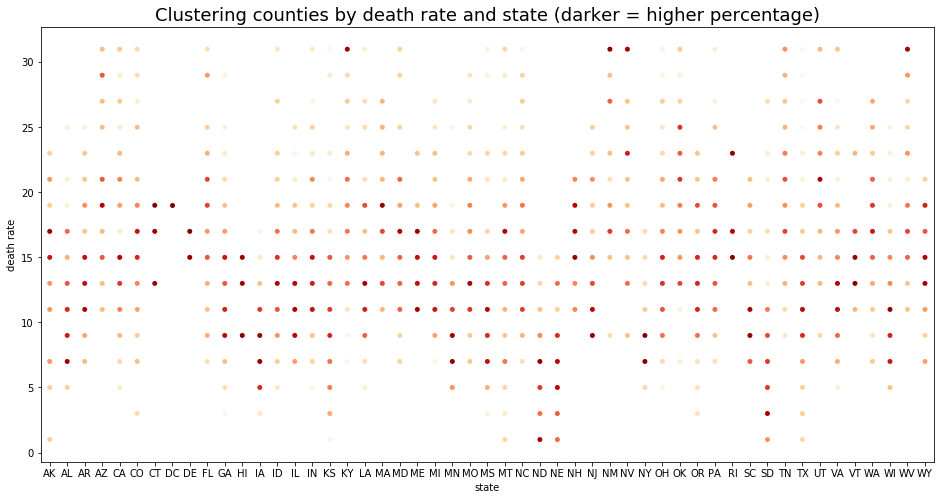

In [369]:
plt.rcParams["figure.figsize"] = [16.0, 8.0]
ax = sns.stripplot(data=counts, x='state', y='numeric', hue='percent', palette='OrRd')
ax.legend_.remove()
ax.set_title('Clustering counties by death rate and state (darker = higher percentage)', size=18)
ax.set_ylabel('death rate')
ax.figure.savefig('images/county_rates.png')

While there are some states with outlying concentrations of counties with low or high death rates, the distribution is fairly even overall.

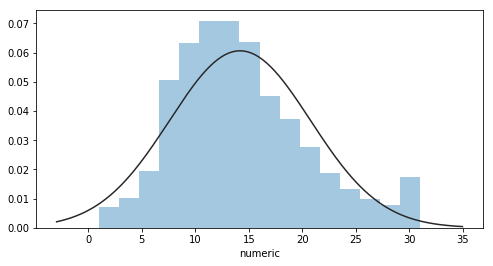

In [370]:
from scipy.stats import norm

plt.rcParams["figure.figsize"] = [8.0, 4.0]
target_hist = sns.distplot(targets['numeric'], bins=16, fit=norm, kde=False)
target_hist.figure.savefig('images/target_hist.png')

The target distribution is a little skewed but follows a roughly normal curve except for the spike at the highest value. Experimentation found that classification works better with these target outliers included, but the outliers in the predictors need to be dealt with.

In [371]:
data_raw = data.copy()
data = data.drop(['state', 'name', 'pop_2014'], axis=1)

In [372]:
bivariate = data.drop(['urban_inf', 'death_rate'], axis=1).corr().abs()
print(bivariate)

               < diploma   degree+   pop_inc  foreign_inc  unemployment  \
< diploma       1.000000  0.596235  0.185915     0.017175      0.444894   
degree+         0.596235  1.000000  0.437384     0.040137      0.344505   
pop_inc         0.185915  0.437384  1.000000     0.003214      0.265479   
foreign_inc     0.017175  0.040137  0.003214     1.000000      0.006487   
unemployment    0.444894  0.344505  0.265479     0.006487      1.000000   
unemp_change    0.099960  0.104568  0.019885     0.001546      0.183943   
poverty         0.676247  0.454771  0.279422     0.016851      0.615135   
median_hh_inc   0.555187  0.682043  0.471092     0.020453      0.472713   
pov_change      0.026931  0.041624  0.043384     0.000316      0.183201   
median_age      0.207144  0.180067  0.366550     0.037000      0.045748   
hh_afr_am       0.337359  0.078255  0.089242     0.001260      0.393471   
hh_hisp         0.416976  0.014507  0.157683     0.001310      0.007594   
hh_female       0.535661 

**poverty** correlates strongly with several other variables, so drop it. The two crime variables correlate strongly with each other, so combine them into one. 

In [373]:
data['crime'] = (data['viol_crime'] + data['prop_crime'])
data = data.drop(['viol_crime', 'prop_crime', 'poverty'], axis=1)

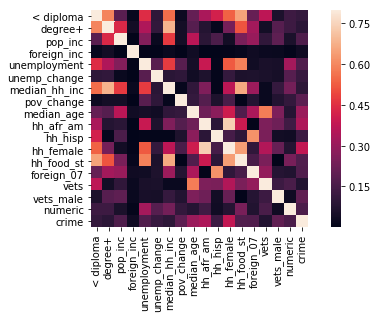

In [374]:
corrmat = data.drop(['urban_inf', 'death_rate'], axis=1).corr().abs()
heatmap = sns.heatmap(corrmat, vmax=.8, square=True)
heatmap.figure.savefig('images/heatmap.png')

There are other correlations, but variance inflation factor (VIF) analysis will be used to determine which should be removed. But first look at outliers in the independent variables.

In [375]:
def get_outliers(df, multiplier=1.5):
    stats = df.describe()
    iqr = stats.loc['75%'] - stats.loc['25%']
    lower = stats.loc['25%'] - multiplier * iqr
    upper = stats.loc['75%'] + multiplier * iqr
    return ((df < lower) | (df > upper))

In [376]:
outliers = get_outliers(data.drop(['urban_inf', 'death_rate', 'numeric'], axis=1))
len(data[outliers.any(axis=1)])

1499

In [377]:
extreme_outliers = get_outliers(data.drop(['urban_inf', 'death_rate', 'numeric'], axis=1), 2.5)
len(data[extreme_outliers.any(axis=1)])

927

In [378]:
xx_outliers = list((data[extreme_outliers.sum(axis=1) > 1]).index)
len(xx_outliers)

273

Almost half the dataset contains outliers, and more than a quarter contains extreme outliers that are more than 2.5 times the IQR below the first quartile or above the third. As an alternative to dropping a large number of samples, apply robust scaling to the predictors. Scikit-learn has two solutions, robust scaling and quantile transformation. Try them both. If necessary drop the most extreme (xx) outliers, those samples having more than one extreme outlier.

*Note: Having gone through the same iterative process as the notebook on the master branch and not achieving significantly better results, the data will be split from the outset to produce balanced train/test sets with respect to high/low death rates, with high being 15 or greater, and low being 13 or less. This will have the desired effect only for the last, binary, classification attempt, as the intermediary classifications into 16, 8 and 4 classes will no longer be stratified according to the progressive grouping scheme.*

In [379]:
from sklearn.model_selection import train_test_split

data['high_death_rate'] = np.where(data['numeric'] < 15, 0, 1)
data_train, data_test, targets_train, targets_test = train_test_split(data.drop('death_rate', axis=1),
                                                                     data['death_rate'], test_size=.2,
                                                                     stratify=data['high_death_rate'], random_state=13)

In [380]:
print(len(data_train[data_train['high_death_rate'] == 0]), len(data_train[data_train['high_death_rate'] == 1]))
print(len(data_test[data_test['high_death_rate'] == 0]), len(data_test[data_test['high_death_rate'] == 1]))

1371 1129
343 283


It is necessary to separate the training and test data before scaling/transforming to prevent data leakage from the test data when fitting the scaling and transformation algorithms. 

In [381]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer
robust = RobustScaler()
quantile = QuantileTransformer()

r_train = pd.DataFrame(robust.fit_transform(data_train.drop(['urban_inf'], axis=1)),
                       index=data_train.index, columns=data_train.drop(['urban_inf'], axis=1).columns)
r_train['urban_inf'] = data_train['urban_inf']

q_train = pd.DataFrame(quantile.fit_transform(data_train.drop(['urban_inf'], axis=1)),
                       index=data_train.index, columns=data_train.drop(['urban_inf'], axis=1).columns)
q_train['urban_inf'] = data_train['urban_inf']

*Note: Both robust scaling and quantile transformation leave binary features unchanged, so __urban_inf__ will be one-hot encoded later.*

Use VIF analysis to programmatically eliminate the variables with the highest VIF scores.

In [382]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
remove = ['urban_inf', 'numeric', 'high_death_rate']
features = r_train.drop(remove, axis=1)
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif["features"] = features.columns
vif

,VIF,features
0,4.373346,< diploma
1,3.102136,degree+
2,1.635238,pop_inc
3,1.008715,foreign_inc
4,1.950713,unemployment
5,1.076284,unemp_change
6,2.967300,median_hh_inc
7,1.137061,pov_change
8,2.286735,median_age
9,2.687256,hh_afr_am


In [383]:
max_VIF = max(vif['VIF'])
while max_VIF > 2:
    remove = remove + list(vif[vif['VIF'] == max_VIF]['features'])
    features = r_train.drop(remove, axis=1)
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif["features"] = features.columns
    max_VIF = max(vif['VIF'])
    
r_features = list(features.columns) + ['urban_inf']
vif

,VIF,features
0,1.389071,degree+
1,1.386369,pop_inc
2,1.006899,foreign_inc
3,1.466743,unemployment
4,1.055496,unemp_change
5,1.091065,pov_change
6,1.503962,hh_afr_am
7,1.120092,hh_hisp
8,1.152088,vets
9,1.198796,vets_male


In [384]:
vif2 = pd.DataFrame()
remove = ['urban_inf', 'numeric', 'high_death_rate']
features2 = q_train.drop(remove, axis=1)
vif2["VIF"] = [variance_inflation_factor(features2.values, i) for i in range(features2.shape[1])]
vif2["features"] = features2.columns
vif2

,VIF,features
0,13.617755,< diploma
1,12.091105,degree+
2,7.061427,pop_inc
3,5.431645,foreign_inc
4,8.187669,unemployment
5,4.314256,unemp_change
6,9.135942,median_hh_inc
7,4.459089,pov_change
8,9.191393,median_age
9,9.543726,hh_afr_am


In [385]:
max_VIF = max(vif2['VIF'])
while len(vif2) > 11:
    remove = remove + list(vif2[vif2['VIF'] == max_VIF]['features'])
    features2 = q_train.drop(remove, axis=1)
    vif2 = pd.DataFrame()
    vif2["VIF"] = [variance_inflation_factor(features2.values, i) for i in range(features2.shape[1])]
    vif2["features"] = features2.columns
    max_VIF = max(vif2['VIF'])

q_features = list(features2.columns) + ['urban_inf']   
vif2

,VIF,features
0,6.154123,degree+
1,5.487159,pop_inc
2,5.146677,foreign_inc
3,5.271207,unemployment
4,3.697811,unemp_change
5,4.403852,pov_change
6,6.333031,hh_afr_am
7,5.333283,hh_hisp
8,3.902017,vets
9,3.218723,vets_male


Although the VIF scores were higher with the quantile-transformed data, the order was the same, so proceed with the 11 features from the scaled data that scored below 2.

Try a range of classifiers. 

In [386]:
Xr1_train = r_train.loc[:, r_features]
Xr1_train = pd.get_dummies(Xr1_train, prefix='urb_inf_', columns=['urban_inf'])
Yr1_train = targets_train

Xq1_train = q_train.loc[:, r_features]
Xq1_train = pd.get_dummies(Xq1_train, prefix='urb_inf_', columns=['urban_inf'])
Yq1_train = targets_train

In [387]:
from sklearn.metrics import matthews_corrcoef, make_scorer
matthews = make_scorer(matthews_corrcoef)

from sklearn.model_selection import cross_val_score

In [388]:
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [389]:
knn = KNeighborsClassifier()
lrc = LogisticRegression(class_weight='balanced')
gbc = GradientBoostingClassifier()
sgd = SGDClassifier(class_weight='balanced', tol=1e-3)
rfc = RandomForestClassifier(class_weight='balanced')
svc = SVC(class_weight='balanced')

In [390]:
classifiers = [lrc, gbc, sgd, rfc, svc, knn]
names = ['lrc', 'gbc', 'sgd', 'rfc', 'svc', 'knn']
full_names = {'lrc':'Logistic regression', 'gbc':'Gradient boosting', 'sgd':'Stochastic gradient descent',
              'rfc':'Random forest', 'svc':'Support vector', 'knn':'K-Nearest neighbors'}

index = pd.MultiIndex.from_product([['Y16', 'Y8', 'Y4', 'Y2'], ['r', 'q'], [1, 2]])
results = pd.DataFrame(index=index, columns=names)

def run_trials(X, Y, targets, scale, feature_set):
    for name, clf in zip(names, classifiers):
        scores = cross_val_score(clf, X, Y, cv=5, scoring=matthews)
        results.loc[targets, scale, feature_set][name] = np.mean(scores)
        %time print('{} scores: {}'.format(full_names[name], scores))

In [391]:
run_trials(Xr1_train, Yr1_train, 'Y16', 'r', 1)

Logistic regression scores: [ 0.05315599  0.05556943  0.06444637  0.04198675  0.07011897]
CPU times: user 1.24 ms, sys: 84 µs, total: 1.33 ms
Wall time: 327 µs
Gradient boosting scores: [ 0.08256715  0.064797    0.08237674  0.04953054  0.07630845]
CPU times: user 288 µs, sys: 53 µs, total: 341 µs
Wall time: 325 µs
Stochastic gradient descent scores: [ 0.04100792  0.02808434  0.03464314  0.0399452   0.04591688]
CPU times: user 1.13 ms, sys: 68 µs, total: 1.2 ms
Wall time: 302 µs
Random forest scores: [ 0.06249914  0.04232645  0.04501504  0.03864918  0.048922  ]
CPU times: user 289 µs, sys: 53 µs, total: 342 µs
Wall time: 326 µs
Support vector scores: [ 0.07117561  0.08622946  0.07061263  0.09856212  0.08473546]
CPU times: user 276 µs, sys: 52 µs, total: 328 µs
Wall time: 311 µs
K-Nearest neighbors scores: [ 0.0420281   0.03601487  0.04234999  0.03835727  0.07488866]
CPU times: user 265 µs, sys: 45 µs, total: 310 µs
Wall time: 301 µs


All of the stock classifiers performed poorly, with support vector doing the best, followed by gradient boosting and logistic regression.

In [392]:
run_trials(Xq1_train, Yq1_train, 'Y16', 'q', 1)

Logistic regression scores: [ 0.05896632  0.04505344  0.07008089  0.03688844  0.06747923]
CPU times: user 1.2 ms, sys: 78 µs, total: 1.28 ms
Wall time: 318 µs
Gradient boosting scores: [ 0.09276963  0.07093395  0.0649071   0.06890127  0.06595253]
CPU times: user 307 µs, sys: 57 µs, total: 364 µs
Wall time: 342 µs
Stochastic gradient descent scores: [ 0.0333818   0.07338809  0.03826221  0.03265811  0.03901862]
CPU times: user 1.28 ms, sys: 80 µs, total: 1.36 ms
Wall time: 336 µs
Random forest scores: [ 0.08085611  0.03291917  0.05503226  0.0450558   0.04539139]
CPU times: user 284 µs, sys: 55 µs, total: 339 µs
Wall time: 317 µs
Support vector scores: [ 0.04360361  0.0377379   0.04886285  0.05765198  0.05097247]
CPU times: user 278 µs, sys: 53 µs, total: 331 µs
Wall time: 314 µs
K-Nearest neighbors scores: [ 0.02792726  0.01254466  0.01152074  0.02477701  0.0418932 ]
CPU times: user 266 µs, sys: 43 µs, total: 309 µs
Wall time: 301 µs


The quantile-transformed data performed even worse. Try an alternative selection process starting with correlations with the target variable.

In [393]:
bivariate = r_train.drop(['urban_inf', 'high_death_rate'], axis=1).corr().abs()
bivariate.loc['numeric'].drop('numeric')

< diploma        0.129802
degree+          0.108880
pop_inc          0.046599
foreign_inc      0.002281
unemployment     0.334084
unemp_change     0.162174
median_hh_inc    0.240524
pov_change       0.097301
median_age       0.070081
hh_afr_am        0.138424
hh_hisp          0.032536
hh_female        0.078814
hh_food_st       0.249716
foreign_07       0.060102
vets             0.132303
vets_male        0.034855
crime            0.159208
Name: numeric, dtype: float64

In [394]:
features2 = list(bivariate[bivariate.loc['numeric'] > .05].drop('numeric').index)

In [395]:
vif = pd.DataFrame()
features = r_train.loc[:, features2]
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif["features"] = features.columns
vif

,VIF,features
0,3.949988,< diploma
1,3.012560,degree+
2,1.886529,unemployment
3,1.067913,unemp_change
4,2.743970,median_hh_inc
5,1.109437,pov_change
6,1.929993,median_age
7,2.521036,hh_afr_am
8,3.830212,hh_female
9,3.382855,hh_food_st


In [396]:
max_VIF = max(vif['VIF'])
while max_VIF > 2:
    remove = list(vif[vif['VIF'] == max_VIF]['features'])
    reduced = [feature for feature in features if feature not in remove]
    features = r_train.loc[:, reduced]
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif["features"] = features.columns
    max_VIF = max(vif['VIF'])
vif

,VIF,features
0,1.352025,degree+
1,1.439612,unemployment
2,1.058117,unemp_change
3,1.080741,pov_change
4,1.736407,median_age
5,1.420526,hh_afr_am
6,1.296802,foreign_07
7,1.631301,vets
8,1.318287,crime


In [397]:
features2 = list(vif['features']) + ['urban_inf']
Xr2_train = r_train.loc[:, features2]
Xr2_train = pd.get_dummies(Xr2_train, prefix='urb_inf_', columns=['urban_inf'])
Yr2_train = targets_train

Xq2_train = q_train.loc[:, (features2)]
Xq2_train = pd.get_dummies(Xq2_train, prefix='urb_inf_', columns=['urban_inf'])
Yq2_train = targets_train

In [398]:
run_trials(Xr2_train, Yr2_train, 'Y16', 'r', 2)

Logistic regression scores: [ 0.08120245  0.03837602  0.05937706  0.05447471  0.05991573]
CPU times: user 1.27 ms, sys: 98 µs, total: 1.37 ms
Wall time: 338 µs
Gradient boosting scores: [ 0.05348211  0.0694086   0.07644137  0.08032138  0.08997899]
CPU times: user 275 µs, sys: 60 µs, total: 335 µs
Wall time: 317 µs
Stochastic gradient descent scores: [ 0.02724636  0.04624746  0.03583727  0.05782837  0.04636617]
CPU times: user 1.13 ms, sys: 72 µs, total: 1.2 ms
Wall time: 302 µs
Random forest scores: [ 0.0471465   0.04370809  0.06200177  0.10204043  0.06391109]
CPU times: user 280 µs, sys: 59 µs, total: 339 µs
Wall time: 319 µs
Support vector scores: [ 0.11107941  0.08165667  0.06313725  0.08311447  0.09857294]
CPU times: user 280 µs, sys: 52 µs, total: 332 µs
Wall time: 317 µs
K-Nearest neighbors scores: [ 0.03706683  0.05379337  0.03768774  0.0268804   0.07501976]
CPU times: user 282 µs, sys: 43 µs, total: 325 µs
Wall time: 315 µs


In [399]:
run_trials(Xq2_train, Yq2_train, 'Y16', 'q', 2)

Logistic regression scores: [ 0.05214331  0.04834291  0.04801482  0.05333938  0.07603927]
CPU times: user 1.21 ms, sys: 80 µs, total: 1.29 ms
Wall time: 319 µs
Gradient boosting scores: [ 0.04048338  0.06832699  0.07687105  0.07161239  0.08316528]
CPU times: user 296 µs, sys: 58 µs, total: 354 µs
Wall time: 335 µs
Stochastic gradient descent scores: [ 0.03329807  0.04776238  0.01818178  0.0317028   0.05522514]
CPU times: user 1.78 ms, sys: 158 µs, total: 1.94 ms
Wall time: 476 µs
Random forest scores: [ 0.03750867  0.09159761  0.08515653  0.08271217  0.03270749]
CPU times: user 290 µs, sys: 56 µs, total: 346 µs
Wall time: 326 µs
Support vector scores: [ 0.04706307  0.04402198  0.05096395  0.05731853  0.0712891 ]
CPU times: user 280 µs, sys: 55 µs, total: 335 µs
Wall time: 316 µs
K-Nearest neighbors scores: [ 0.04165052  0.03389312  0.05255951  0.0518747   0.05721658]
CPU times: user 263 µs, sys: 43 µs, total: 306 µs
Wall time: 300 µs


The scores are very close for both training sets, but also very poor. Try combining targets to make fewer classes.

In [400]:
def combine_targets(input):
    targets = sorted(input.unique(), key=lambda x: int(re.search('\d+(?=-)', x).group()))
    first = []
    second = []
    for i, r in enumerate(targets):
        first.append(r) if i % 2 == 0 else second.append(r)
    if len(first) != len(second):
        second.append('30-31.9')
    conversions = {}
    for start, end in zip(first, second):
        new_value = re.search('\d+-', start).group() + re.search('(?<=-)\d+.\d+', end).group()
        conversions.update(dict.fromkeys([start, end], new_value))
    return input.apply(lambda x: conversions[x])

In [401]:
Y_16_train = targets_train.apply(lambda x: '0-1.9' if x == '<2' else x)
Y_16_train = Y_16_train.apply(lambda x: '30-31.9' if x == '30+' else x)

Y_8_train = combine_targets(Y_16_train)


In [402]:
run_trials(Xr1_train, Y_8_train, 'Y8', 'r', 1)

Logistic regression scores: [ 0.1006998   0.15027161  0.13541833  0.12946323  0.1468057 ]
CPU times: user 1.22 ms, sys: 81 µs, total: 1.3 ms
Wall time: 322 µs
Gradient boosting scores: [ 0.12492481  0.13869989  0.13538485  0.16721217  0.13833912]
CPU times: user 273 µs, sys: 52 µs, total: 325 µs
Wall time: 309 µs
Stochastic gradient descent scores: [ 0.11173697  0.02615689  0.07056545  0.07764471  0.01695733]
CPU times: user 1.18 ms, sys: 92 µs, total: 1.27 ms
Wall time: 316 µs
Random forest scores: [ 0.08393604  0.09365307  0.08126177  0.12787424  0.08993542]
CPU times: user 284 µs, sys: 54 µs, total: 338 µs
Wall time: 321 µs
Support vector scores: [ 0.11206608  0.161711    0.12389991  0.16337382  0.15331281]
CPU times: user 281 µs, sys: 50 µs, total: 331 µs
Wall time: 315 µs
K-Nearest neighbors scores: [ 0.12779606  0.0575085   0.11942509  0.12490683  0.14238761]
CPU times: user 272 µs, sys: 30 µs, total: 302 µs
Wall time: 308 µs


In [403]:
run_trials(Xr2_train, Y_8_train, 'Y8', 'r', 2)

Logistic regression scores: [ 0.09360022  0.13562208  0.1233944   0.12577249  0.15457289]
CPU times: user 1.2 ms, sys: 78 µs, total: 1.27 ms
Wall time: 316 µs
Gradient boosting scores: [ 0.12701564  0.11388018  0.15566788  0.17614289  0.12260446]
CPU times: user 287 µs, sys: 56 µs, total: 343 µs
Wall time: 327 µs
Stochastic gradient descent scores: [ 0.00377578  0.05738334  0.11604968  0.07115296  0.11204089]
CPU times: user 1.5 ms, sys: 97 µs, total: 1.6 ms
Wall time: 406 µs
Random forest scores: [ 0.13507316  0.12041214  0.10354952  0.12509279  0.1076325 ]
CPU times: user 281 µs, sys: 47 µs, total: 328 µs
Wall time: 316 µs
Support vector scores: [ 0.16068255  0.14482644  0.14215889  0.16919535  0.17270301]
CPU times: user 274 µs, sys: 50 µs, total: 324 µs
Wall time: 310 µs
K-Nearest neighbors scores: [ 0.11159673  0.12634983  0.1460032   0.08832114  0.16423142]
CPU times: user 268 µs, sys: 49 µs, total: 317 µs
Wall time: 307 µs


In [404]:
run_trials(Xq1_train, Y_8_train, 'Y8', 'q', 1)

Logistic regression scores: [ 0.12669076  0.12082226  0.11758375  0.11417803  0.1467096 ]
CPU times: user 2.44 ms, sys: 165 µs, total: 2.61 ms
Wall time: 641 µs
Gradient boosting scores: [ 0.15210284  0.15830065  0.13192102  0.17994627  0.12702041]
CPU times: user 280 µs, sys: 52 µs, total: 332 µs
Wall time: 315 µs
Stochastic gradient descent scores: [ 0.08667925  0.10701711  0.06232469  0.09332838  0.13617045]
CPU times: user 1.21 ms, sys: 85 µs, total: 1.29 ms
Wall time: 322 µs
Random forest scores: [ 0.10825277  0.11081648  0.10301716  0.16382522  0.08413585]
CPU times: user 282 µs, sys: 53 µs, total: 335 µs
Wall time: 318 µs
Support vector scores: [ 0.11883457  0.10128429  0.12849027  0.1018431   0.13720605]
CPU times: user 279 µs, sys: 75 µs, total: 354 µs
Wall time: 326 µs
K-Nearest neighbors scores: [ 0.105686    0.04634389  0.08872399  0.11473222  0.07343662]
CPU times: user 257 µs, sys: 29 µs, total: 286 µs
Wall time: 291 µs


In [405]:
run_trials(Xq2_train, Y_8_train, 'Y8', 'q', 2)

Logistic regression scores: [ 0.10290686  0.12109077  0.10614412  0.13051264  0.16082355]
CPU times: user 1.62 ms, sys: 134 µs, total: 1.75 ms
Wall time: 431 µs
Gradient boosting scores: [ 0.13365935  0.11678717  0.16155196  0.16122405  0.14017992]
CPU times: user 304 µs, sys: 112 µs, total: 416 µs
Wall time: 376 µs
Stochastic gradient descent scores: [ 0.08101007  0.05038097  0.07524041  0.09880267  0.11632392]
CPU times: user 1.15 ms, sys: 66 µs, total: 1.22 ms
Wall time: 304 µs
Random forest scores: [ 0.10816525  0.06614877  0.07907206  0.12964863  0.13518754]
CPU times: user 271 µs, sys: 47 µs, total: 318 µs
Wall time: 306 µs
Support vector scores: [ 0.11003132  0.12328048  0.08497923  0.11596158  0.16563487]
CPU times: user 276 µs, sys: 64 µs, total: 340 µs
Wall time: 325 µs
K-Nearest neighbors scores: [ 0.07821737  0.06529068  0.12167276  0.12566131  0.11805024]
CPU times: user 262 µs, sys: 50 µs, total: 312 µs
Wall time: 301 µs


There was significant improvement, but performance is still poor. Try reducing to 4 classes.

In [406]:
Y_4_train = combine_targets(Y_8_train)

In [407]:
run_trials(Xr1_train, Y_4_train, 'Y4', 'r', 1)

Logistic regression scores: [ 0.25462875  0.22164089  0.27185536  0.2518097   0.2610493 ]
CPU times: user 1.34 ms, sys: 96 µs, total: 1.43 ms
Wall time: 357 µs
Gradient boosting scores: [ 0.29137624  0.16810738  0.31774703  0.23301689  0.26639206]
CPU times: user 270 µs, sys: 50 µs, total: 320 µs
Wall time: 305 µs
Stochastic gradient descent scores: [ 0.06933538  0.14913115  0.25052273  0.16039151  0.15964135]
CPU times: user 1.14 ms, sys: 70 µs, total: 1.21 ms
Wall time: 302 µs
Random forest scores: [ 0.19858604  0.18426156  0.2351521   0.18824265  0.2024505 ]
CPU times: user 283 µs, sys: 52 µs, total: 335 µs
Wall time: 319 µs
Support vector scores: [ 0.28030463  0.23405757  0.28216966  0.26609776  0.26125599]
CPU times: user 278 µs, sys: 52 µs, total: 330 µs
Wall time: 313 µs
K-Nearest neighbors scores: [ 0.26297784  0.15598445  0.21257458  0.21811632  0.26948666]
CPU times: user 262 µs, sys: 45 µs, total: 307 µs
Wall time: 299 µs


In [408]:
run_trials(Xr2_train, Y_4_train, 'Y4', 'r', 2)

Logistic regression scores: [ 0.25587575  0.21260522  0.26961122  0.26027286  0.22438117]
CPU times: user 1.25 ms, sys: 83 µs, total: 1.33 ms
Wall time: 330 µs
Gradient boosting scores: [ 0.25460606  0.21143096  0.34835194  0.27101483  0.25395302]
CPU times: user 270 µs, sys: 60 µs, total: 330 µs
Wall time: 310 µs
Stochastic gradient descent scores: [ 0.20830201  0.12940491  0.13123714  0.1252904   0.22247151]
CPU times: user 1.24 ms, sys: 88 µs, total: 1.33 ms
Wall time: 334 µs
Random forest scores: [ 0.22437825  0.1944227   0.24193539  0.22353346  0.23565156]
CPU times: user 281 µs, sys: 54 µs, total: 335 µs
Wall time: 320 µs
Support vector scores: [ 0.31135434  0.22896785  0.30134528  0.26801159  0.27662481]
CPU times: user 287 µs, sys: 64 µs, total: 351 µs
Wall time: 323 µs
K-Nearest neighbors scores: [ 0.21139027  0.17011536  0.27060003  0.20758693  0.19872743]
CPU times: user 267 µs, sys: 45 µs, total: 312 µs
Wall time: 301 µs


In [409]:
run_trials(Xq1_train, Y_4_train, 'Y4', 'q', 1)

Logistic regression scores: [ 0.26059135  0.2184687   0.22012332  0.26271878  0.24185575]
CPU times: user 1.2 ms, sys: 83 µs, total: 1.28 ms
Wall time: 318 µs
Gradient boosting scores: [ 0.25050924  0.19443014  0.29527734  0.23024506  0.22839915]
CPU times: user 268 µs, sys: 53 µs, total: 321 µs
Wall time: 304 µs
Stochastic gradient descent scores: [ 0.23015954  0.1340741   0.23448804  0.21878133  0.14455995]
CPU times: user 1.14 ms, sys: 78 µs, total: 1.22 ms
Wall time: 307 µs
Random forest scores: [ 0.17638816  0.20080154  0.24312462  0.18849248  0.19385961]
CPU times: user 304 µs, sys: 94 µs, total: 398 µs
Wall time: 361 µs
Support vector scores: [ 0.25980482  0.18858476  0.2312886   0.21470175  0.23107024]
CPU times: user 482 µs, sys: 125 µs, total: 607 µs
Wall time: 545 µs
K-Nearest neighbors scores: [ 0.17416892  0.20302127  0.13195461  0.16892895  0.16185769]
CPU times: user 278 µs, sys: 46 µs, total: 324 µs
Wall time: 312 µs


In [410]:
run_trials(Xq2_train, Y_4_train, 'Y4', 'q', 2)

Logistic regression scores: [ 0.2416237   0.23345922  0.19742871  0.26547855  0.24984003]
CPU times: user 1.22 ms, sys: 80 µs, total: 1.3 ms
Wall time: 321 µs
Gradient boosting scores: [ 0.22967491  0.19436756  0.34261176  0.27575721  0.25982066]
CPU times: user 292 µs, sys: 53 µs, total: 345 µs
Wall time: 334 µs
Stochastic gradient descent scores: [ 0.18417232  0.09729481  0.19788944  0.12554727  0.12565887]
CPU times: user 1.14 ms, sys: 69 µs, total: 1.21 ms
Wall time: 303 µs
Random forest scores: [ 0.19279918  0.15867677  0.21249106  0.25581251  0.17193492]
CPU times: user 281 µs, sys: 51 µs, total: 332 µs
Wall time: 316 µs
Support vector scores: [ 0.24131892  0.19195784  0.25302771  0.21572503  0.25680344]
CPU times: user 276 µs, sys: 53 µs, total: 329 µs
Wall time: 313 µs
K-Nearest neighbors scores: [ 0.14242785  0.16308059  0.21554408  0.2258976   0.21281599]
CPU times: user 301 µs, sys: 43 µs, total: 344 µs
Wall time: 340 µs


In [411]:
Y_2_train = data_train.loc[:, 'high_death_rate']

In [412]:
run_trials(Xr1_train, Y_2_train, 'Y2', 'r', 1)

Logistic regression scores: [ 0.39451092  0.39218697  0.42309783  0.4034707   0.38586012]
CPU times: user 287 µs, sys: 48 µs, total: 335 µs
Wall time: 325 µs
Gradient boosting scores: [ 0.47388139  0.42093849  0.46059075  0.48188324  0.40974829]
CPU times: user 308 µs, sys: 57 µs, total: 365 µs
Wall time: 343 µs
Stochastic gradient descent scores: [ 0.2497346   0.2845312   0.26458635  0.13233788  0.33601724]
CPU times: user 282 µs, sys: 44 µs, total: 326 µs
Wall time: 319 µs
Random forest scores: [ 0.39939424  0.3777723   0.44070212  0.30682498  0.31385294]
CPU times: user 303 µs, sys: 51 µs, total: 354 µs
Wall time: 340 µs
Support vector scores: [ 0.45184232  0.41691323  0.46700224  0.47224465  0.42736424]
CPU times: user 277 µs, sys: 50 µs, total: 327 µs
Wall time: 312 µs
K-Nearest neighbors scores: [ 0.3329838   0.3696005   0.38616879  0.38603804  0.35150474]
CPU times: user 262 µs, sys: 66 µs, total: 328 µs
Wall time: 312 µs


In [413]:
run_trials(Xr2_train, Y_2_train, 'Y2', 'r', 2)

Logistic regression scores: [ 0.41376057  0.3970782   0.43985365  0.3766551   0.39901955]
CPU times: user 272 µs, sys: 48 µs, total: 320 µs
Wall time: 307 µs
Gradient boosting scores: [ 0.44614141  0.40408787  0.45519193  0.43569737  0.40648672]
CPU times: user 304 µs, sys: 54 µs, total: 358 µs
Wall time: 340 µs
Stochastic gradient descent scores: [ 0.26355815  0.3947627   0.28053664  0.29727077  0.35507596]
CPU times: user 279 µs, sys: 44 µs, total: 323 µs
Wall time: 316 µs
Random forest scores: [ 0.42262064  0.41077872  0.35746024  0.35398611  0.35108838]
CPU times: user 311 µs, sys: 49 µs, total: 360 µs
Wall time: 345 µs
Support vector scores: [ 0.46987999  0.44789308  0.49360341  0.49642595  0.46719861]
CPU times: user 279 µs, sys: 50 µs, total: 329 µs
Wall time: 312 µs
K-Nearest neighbors scores: [ 0.35929697  0.367042    0.4193313   0.3364879   0.40502098]
CPU times: user 265 µs, sys: 33 µs, total: 298 µs
Wall time: 304 µs


In [414]:
run_trials(Xq1_train, Y_2_train, 'Y2', 'q', 1)

Logistic regression scores: [ 0.37029346  0.32605031  0.37117117  0.29880871  0.31262683]
CPU times: user 287 µs, sys: 49 µs, total: 336 µs
Wall time: 324 µs
Gradient boosting scores: [ 0.47388139  0.41705299  0.44813683  0.47377946  0.40648672]
CPU times: user 278 µs, sys: 56 µs, total: 334 µs
Wall time: 314 µs
Stochastic gradient descent scores: [ 0.32275697  0.26981677  0.26968657  0.29603395  0.31045082]
CPU times: user 260 µs, sys: 43 µs, total: 303 µs
Wall time: 296 µs
Random forest scores: [ 0.38858408  0.44373718  0.38898701  0.44166233  0.34737193]
CPU times: user 279 µs, sys: 55 µs, total: 334 µs
Wall time: 312 µs
Support vector scores: [ 0.36791754  0.32072353  0.38656573  0.33971667  0.35434298]
CPU times: user 277 µs, sys: 45 µs, total: 322 µs
Wall time: 307 µs
K-Nearest neighbors scores: [ 0.30580721  0.34976053  0.31358819  0.36972068  0.32300833]
CPU times: user 269 µs, sys: 46 µs, total: 315 µs
Wall time: 304 µs


In [415]:
run_trials(Xq2_train, Y_2_train, 'Y2', 'q', 2)

Logistic regression scores: [ 0.34437895  0.33901008  0.35579413  0.30541059  0.3133327 ]
CPU times: user 270 µs, sys: 45 µs, total: 315 µs
Wall time: 298 µs
Gradient boosting scores: [ 0.43065489  0.38753658  0.45093986  0.42326717  0.43030972]
CPU times: user 274 µs, sys: 55 µs, total: 329 µs
Wall time: 314 µs
Stochastic gradient descent scores: [ 0.287741    0.28763034  0.24886374  0.2305693   0.27007284]
CPU times: user 268 µs, sys: 44 µs, total: 312 µs
Wall time: 304 µs
Random forest scores: [ 0.39923639  0.39426965  0.39426965  0.37588996  0.33006665]
CPU times: user 413 µs, sys: 69 µs, total: 482 µs
Wall time: 497 µs
Support vector scores: [ 0.33752748  0.37491046  0.37029121  0.32148483  0.31480401]
CPU times: user 278 µs, sys: 58 µs, total: 336 µs
Wall time: 313 µs
K-Nearest neighbors scores: [ 0.29661711  0.31797896  0.33702727  0.3715814   0.3164191 ]
CPU times: user 266 µs, sys: 48 µs, total: 314 µs
Wall time: 304 µs


In [416]:
results

lrc        gbc        sgd        rfc        svc        knn
Y16 r 1  0.0570555   0.071116  0.0379195  0.0474824  0.0822631  0.0467278
      2  0.0586692  0.0739265  0.0427051  0.0637616  0.0875121  0.0460896
    q 1  0.0556937  0.0726929  0.0433418  0.0518509  0.0477658  0.0237326
      2  0.0555759  0.0680918   0.037234  0.0659365  0.0541313  0.0474389
Y8  r 1   0.132532   0.140912  0.0606123  0.0953321   0.142873   0.114405
      2   0.126592   0.139062  0.0720805   0.118352   0.157913     0.1273
    q 1   0.125197   0.149858   0.097104   0.114009   0.117532  0.0857845
      2   0.124296    0.14268  0.0843516   0.103644   0.119977   0.101778
Y4  r 1   0.252197   0.255328   0.157804   0.201739   0.264777   0.223828
      2   0.244549   0.267871   0.163341   0.223984   0.277261   0.211684
    q 1   0.240752   0.239772   0.192413   0.200533    0.22509   0.167986
      2   0.237566   0.260446   0.146113   0.198343   0.231767   0.191953
Y2  r 1   0.399825   0.449408   0.253441   0.367709   0.447073   0.365259
      2   0.405273   0.429521   0.318241   0.379187      0.475   0.377436
    q 1    0.33579   0.443867   0.293749   0.402069   0.353853   0.332377
      2   0.331585   0.424542   0.264975   0.378746   0.343804   0.327925

The data cannot perform better than reasonably well on binary classification, where robust scaling clearly outperforms quantile transformation on the three highest-scoring algorithms — support vector, logistic regression amd gradient boosting. The second feature set performs better, but would performance improve by dropping the most extreme outliers?

In [417]:
train_xx = list(set(xx_outliers) & set(list(data_train.index)))
test_xx = list(set(xx_outliers) & set(list(data_test.index)))

In [418]:
Xr1_noxx_train = Xr1_train.drop(train_xx)
Xr2_noxx_train = Xr2_train.drop(train_xx)
Y_2_noxx_train = Y_2_train.drop(train_xx)

In [419]:
index2 = pd.MultiIndex.from_product([['full', 'no_xx'], [1, 2]])
results2 = pd.DataFrame(index=index2, columns=names)

results2.loc['full', 1] = results.loc['Y2', 'r', 1]
results2.loc['full', 2] = results.loc['Y2', 'r', 2]


def run_trials2(X, Y, selected, feature_set):
    for name, clf in zip(names, classifiers):
        score = np.mean(cross_val_score(clf, X, Y, cv=5, scoring=matthews))
        results2.loc[selected, feature_set][name] = score
        %time print('{} average score: {}'.format(full_names[name], score))

In [420]:
run_trials2(Xr1_noxx_train, Y_2_noxx_train, 'no_xx', 1)

Logistic regression average score: 0.4247664845496376
CPU times: user 84 µs, sys: 59 µs, total: 143 µs
Wall time: 129 µs
Gradient boosting average score: 0.43310502932319245
CPU times: user 81 µs, sys: 55 µs, total: 136 µs
Wall time: 118 µs
Stochastic gradient descent average score: 0.24351096780284479
CPU times: user 66 µs, sys: 40 µs, total: 106 µs
Wall time: 98 µs
Random forest average score: 0.37938462316443866
CPU times: user 70 µs, sys: 53 µs, total: 123 µs
Wall time: 112 µs
Support vector average score: 0.45486077422022647
CPU times: user 81 µs, sys: 56 µs, total: 137 µs
Wall time: 117 µs
K-Nearest neighbors average score: 0.3751529067815852
CPU times: user 60 µs, sys: 32 µs, total: 92 µs
Wall time: 97 µs


In [421]:
run_trials2(Xr2_noxx_train, Y_2_noxx_train, 'no_xx', 2)

Logistic regression average score: 0.4153626271700427
CPU times: user 71 µs, sys: 49 µs, total: 120 µs
Wall time: 106 µs
Gradient boosting average score: 0.43965955506396376
CPU times: user 83 µs, sys: 55 µs, total: 138 µs
Wall time: 121 µs
Stochastic gradient descent average score: 0.2660313335096859
CPU times: user 65 µs, sys: 43 µs, total: 108 µs
Wall time: 101 µs
Random forest average score: 0.3989229154237815
CPU times: user 68 µs, sys: 42 µs, total: 110 µs
Wall time: 104 µs
Support vector average score: 0.4685448042226986
CPU times: user 79 µs, sys: 54 µs, total: 133 µs
Wall time: 116 µs
K-Nearest neighbors average score: 0.38238270214170966
CPU times: user 58 µs, sys: 33 µs, total: 91 µs
Wall time: 95.8 µs


In [422]:
results2

lrc       gbc       sgd       rfc       svc       knn
full  1  0.399825  0.449408  0.253441  0.367709  0.447073  0.365259
      2  0.405273  0.429521  0.318241  0.379187     0.475  0.377436
no_xx 1  0.424766  0.433105  0.243511  0.379385  0.454861  0.375153
      2  0.415363   0.43966  0.266031  0.398923  0.468545  0.382383

The choices between the full dataset or the dataset without the most extreme outliers, and between the feaure sets is not clear. See how the top three models perform on the test set.

In [423]:
r_test = pd.DataFrame(robust.fit_transform(data_test.drop(['urban_inf'], axis=1)),
                       index=data_test.index, columns=data_test.drop(['urban_inf'], axis=1).columns)
r_test['urban_inf'] = data_test['urban_inf']

Xr1_test = r_test.loc[:, r_features]
Xr1_test = pd.get_dummies(Xr1_test, prefix='urb_inf_', columns=['urban_inf'])

Xr2_test = r_test.loc[:, features2]
Xr2_test = pd.get_dummies(Xr2_test, prefix='urb_inf_', columns=['urban_inf'])

Xr1_noxx_test = r_test.loc[:, r_features].drop(test_xx)
Xr1_noxx_test = pd.get_dummies(Xr1_noxx_test, prefix='urb_inf_', columns=['urban_inf'])

Xr2_noxx_test = r_test.loc[:, features2].drop(test_xx)
Xr2_noxx_test = pd.get_dummies(Xr2_noxx_test, prefix='urb_inf_', columns=['urban_inf'])

Y_2_test = data_test.loc[:, 'high_death_rate']
Y_2_noxx_test = Y_2_test.drop(test_xx)

In [424]:
index3 = pd.MultiIndex.from_product([['full', 'no_xx'], [1, 2]])
names3 = ['lrc', 'gbc', 'svc']
classifiers3 = [classifiers[i] for i in [0, 1, 4]]
results3 = pd.DataFrame(index=index3, columns=names3)

def run_trials3(X_train, X_test, Y_train, Y_test, selected, feature_set):
    for name, clf in zip(names3, classifiers3):
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        score = matthews_corrcoef(Y_test, Y_pred)
        results3.loc[selected, feature_set][name] = score
        %time print('{} average score: {}'.format(full_names[name], score))

In [425]:
run_trials3(Xr1_train, Xr1_test, Y_2_train, Y_2_test, 'full', 1)

Logistic regression average score: 0.4254933674749412
CPU times: user 446 µs, sys: 102 µs, total: 548 µs
Wall time: 139 µs
Gradient boosting average score: 0.46750981979707357
CPU times: user 80 µs, sys: 53 µs, total: 133 µs
Wall time: 116 µs
Support vector average score: 0.44690008305811424
CPU times: user 81 µs, sys: 52 µs, total: 133 µs
Wall time: 120 µs


In [426]:
run_trials3(Xr2_train, Xr2_test, Y_2_train, Y_2_test, 'full', 2)

Logistic regression average score: 0.44005573725072195
CPU times: user 494 µs, sys: 177 µs, total: 671 µs
Wall time: 195 µs
Gradient boosting average score: 0.4666216241085279
CPU times: user 88 µs, sys: 66 µs, total: 154 µs
Wall time: 125 µs
Support vector average score: 0.4513690984910804
CPU times: user 83 µs, sys: 57 µs, total: 140 µs
Wall time: 117 µs


In [427]:
run_trials3(Xr1_noxx_train, Xr1_noxx_test, Y_2_noxx_train, Y_2_noxx_test, 'no_xx', 1)

Logistic regression average score: 0.4289254381995234
CPU times: user 565 µs, sys: 100 µs, total: 665 µs
Wall time: 163 µs
Gradient boosting average score: 0.47565070207723426
CPU times: user 77 µs, sys: 51 µs, total: 128 µs
Wall time: 112 µs
Support vector average score: 0.4447437028487351
CPU times: user 92 µs, sys: 60 µs, total: 152 µs
Wall time: 131 µs


In [428]:
run_trials3(Xr2_noxx_train, Xr2_noxx_test, Y_2_noxx_train, Y_2_noxx_test, 'no_xx', 2)

Logistic regression average score: 0.4218723716240062
CPU times: user 75 µs, sys: 57 µs, total: 132 µs
Wall time: 115 µs
Gradient boosting average score: 0.4377136427686071
CPU times: user 71 µs, sys: 51 µs, total: 122 µs
Wall time: 106 µs
Support vector average score: 0.4696203274795283
CPU times: user 59 µs, sys: 31 µs, total: 90 µs
Wall time: 94.4 µs


In [429]:
results3

lrc       gbc       svc
full  1  0.425493   0.46751    0.4469
      2  0.440056  0.466622  0.451369
no_xx 1  0.428925  0.475651  0.444744
      2  0.421872  0.437714   0.46962

The scores are very comparable, but the full dataset achieved more consistent results and handles all the samples, so that will be chosen. It achieved its best and most consistent results with the second feature set. Gradient boosting and support vector performed better than logistic regression; both will be optimized.  

In [430]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [431]:
def optimize(clf, params, X_train, X_test, Y_train, Y_test):
    model = GridSearchCV(clf, param_grid=params, cv=4, scoring=matthews)
    model.fit(X_train, Y_train)
    print('Optimal parameters: {}'.format(model.best_params_))
    preds = model.predict(X_test)
    print('Matthews score: {}'.format(matthews_corrcoef(Y_test, preds)))
    print('ROC-AUC score: {}'.format(roc_auc_score(Y_test, preds)))
    print(confusion_matrix(Y_test, preds))
    residuals = pd.DataFrame(model.best_estimator_.decision_function(X_test))
    plt.scatter(residuals.index, residuals)
    return model

In [441]:
gbc_params = { 'loss': ['deviance', 'exponential'], 'learning_rate': [.05, .1, .15],
                'n_estimators': [25, 50, 75], 'max_depth': [3, 4, 5],
                'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3]}

svc_params = {'C': [0.5, 1, 4, 7], 'kernel': ['linear', 'poly', 'rbf'],
             'gamma': [0.1, 0.12, 0.14], 'tol': [1e-7, 5e-7, 1e-6, 5e-6]}


Optimal parameters: {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Matthews score: 0.4529323068405016
ROC-AUC score: 0.7268437915297367
[[255  88]
 [ 82 201]]


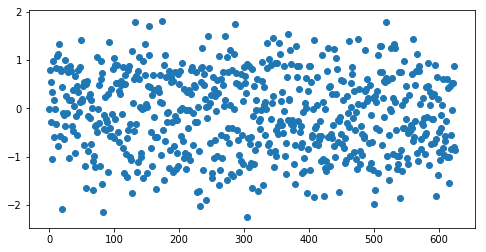

In [442]:
gbc_1 = optimize(gbc, gbc_params, Xr2_train, Xr2_test, Y_2_train, Y_2_test)

Optimal parameters: {'C': 1, 'gamma': 0.12, 'kernel': 'rbf', 'tol': 1e-07}
Matthews score: 0.4561386121555704
ROC-AUC score: 0.7290072010631612
[[248  95]
 [ 75 208]]


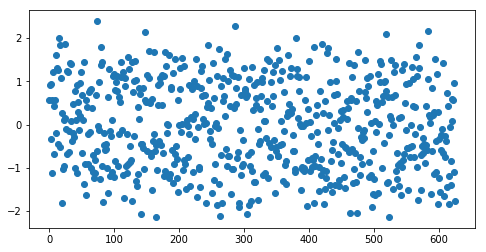

In [434]:
svc_1 = optimize(svc, svc_params, Xr2_train, Xr2_test, Y_2_train, Y_2_test)

In [435]:
def optimize2(clf, params, data, features, rand):
    
    predictors = data.loc[:, features]
    targets = data.loc[:, 'high_death_rate']
    
    data_train, data_test, Y_train, Y_test = train_test_split(predictors, targets, test_size=.2,
                                                                stratify=targets, random_state=rand)
    X_train = pd.DataFrame(robust.fit_transform(data_train.drop(['urban_inf'], axis=1)),
                           index=data_train.index, columns=data_train.drop(['urban_inf'], axis=1).columns)
    X_train['urban_inf'] = data_train['urban_inf']
    
    X_test = pd.DataFrame(robust.fit_transform(data_test.drop(['urban_inf'], axis=1)),
                       index=data_test.index, columns=data_test.drop(['urban_inf'], axis=1).columns)
    X_test['urban_inf'] = data_test['urban_inf']

    X_train = pd.get_dummies(X_train, prefix='urb_inf_', columns=['urban_inf'])
    X_test = pd.get_dummies(X_test, prefix='urb_inf_', columns=['urban_inf'])


    model = GridSearchCV(clf, param_grid=params, cv=4, scoring=matthews)
    model.fit(X_train, Y_train)
    print('Optimal parameters: {}'.format(model.best_params_))
    preds = model.predict(X_test)
    print('Matthews score: {}'.format(matthews_corrcoef(Y_test, preds)))
    print('ROC-AUC score: {}'.format(roc_auc_score(Y_test, preds)))
    print(confusion_matrix(Y_test, preds))
    residuals = pd.DataFrame(model.best_estimator_.decision_function(X_test))
    plt.scatter(residuals.index, residuals)
    return model

In [436]:
df = data.drop(['death_rate', 'numeric'], axis=1)

Optimal parameters: {'learning_rate': 0.15, 'loss': 'deviance', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 75}
Matthews score: 0.4127847287155152
ROC-AUC score: 0.7062604951117246
[[253  90]
 [ 92 191]]


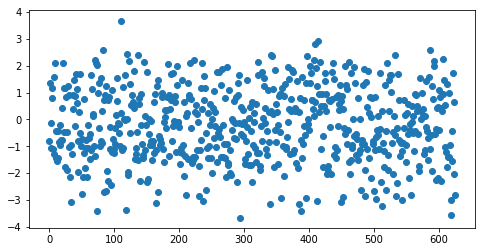

In [443]:
gbc2 = optimize2(gbc, gbc_params, df, features2, 37)

Optimal parameters: {'C': 4, 'gamma': 0.1, 'kernel': 'rbf', 'tol': 1e-07}
Matthews score: 0.4673331274241291
ROC-AUC score: 0.7347041795011796
[[241 102]
 [ 66 217]]


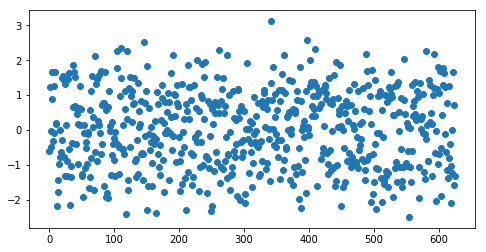

In [438]:
svc2 = optimize2(svc, svc_params, df, features2, 37)

Experimentation found cross-validation with 4 folds to work best. Gradient boosting is not stable with respect to the split in the dataset, whereas support vector is. The results are very close to those obtained when the unscaled dataset was used for feature selection. Support vector with the second data split achieved the highest score of any classifier, but the results are not as consistent as with feature selection on the unscaled data.

In [439]:
svc3 = SVC(C=1, gamma=.12, kernel='linear', tol=1e-7)
svc3.fit(Xr2_train, Y_2_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.12, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=1e-07, verbose=False)

In [440]:
feature_rank = zip(Xr2_train.columns, svc3.coef_[0])
results = sorted(feature_rank, key=lambda tup: tup[1], reverse=True)
for f, r in results:
    print('{:13.12}: {:8.5f}'.format(f, r))

unemployment :  0.98015
crime        :  0.71538
urb_inf__1   :  0.50996
urb_inf__4   :  0.46740
urb_inf__10  :  0.29202
urb_inf__11  :  0.22026
urb_inf__7   :  0.15704
median_age   :  0.15343
vets         :  0.14107
pov_change   :  0.12578
urb_inf__2   :  0.09748
urb_inf__12  :  0.00751
urb_inf__8   : -0.02618
degree+      : -0.07020
foreign_07   : -0.15419
urb_inf__3   : -0.19384
urb_inf__6   : -0.21813
unemp_change : -0.31416
urb_inf__9   : -0.33255
hh_afr_am    : -0.55512
urb_inf__5   : -0.98098
